#### Clustering games/tags on tags co_occurence matrix

In [ ]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
from reco_systems.evaluation import *
from copy import *

%load_ext autoreload
%autoreload 2

In [ ]:
# import DB et set min_reviews

folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 15 # change to set one

In [3]:
# game - tags matrix 
avis_clean = filter_df(avis_clean, min_reviews)
avis_jeux = jeux_clean[["Game id", "Type"]].merge(avis_clean[["User id", "Game id", "Rating"]], on='Game id').dropna()

# for each category create a new row
types = avis_jeux['Type'].str.split('|').explode()
user_game_type = pd.DataFrame({
    'User id': avis_jeux['User id'].repeat(avis_jeux['Type'].str.split('|').apply(len)),
    'Game id': avis_jeux['Game id'].repeat(avis_jeux['Type'].str.split('|').apply(len)),
    'Type': types
})

11201 10549
1640 1824
1316 1752
1304 1743
1302 1743


In [4]:
# keep only the games and tags
game_type = user_game_type[["Game id", "Type"]].drop_duplicates().pivot_table(index ="Game id", columns="Type", aggfunc='size', fill_value=0)
# user_type = user_game_type[["User id", "Type"]].drop_duplicates().pivot_table(index ="User id", columns="Type", aggfunc='size', fill_value=0)

In [7]:
#  co occurence matrix
co_occ_games = game_type @ game_type.T # game - game matrix, shared tags
co_occ = game_type.T @ game_type # tags tags matrix, shared games

# co_occ_user = user_type @ user_type.T
# set the diagonal to 0 to not have bias during clustering
np.fill_diagonal(co_occ.values, 0)
np.fill_diagonal(co_occ_games.values, 0)

In [6]:
# plt.matshow(co_occ_games, interpolation="none")
# plt.colorbar()
# plt.show()

In [12]:
# normalisation
game_type_norm = game_type.div(game_type.sum(axis=0), axis=1)
co_occ_norm = game_type_norm.T @ game_type_norm

game_type_norm = game_type.div(game_type.sum(axis=1), axis=0)
co_occ_games_norm = game_type_norm @ game_type_norm.T

# user_type_norm = user_type.div(user_type.sum(axis=1), axis=0)
# co_occ_user_norm = user_type_norm @ user_type_norm.T

np.fill_diagonal(co_occ_norm.values, 0)
np.fill_diagonal(co_occ_games_norm.values, 0)

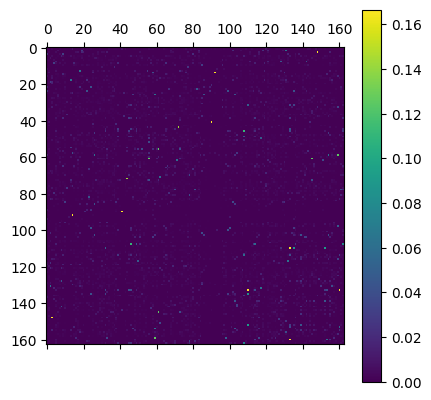

In [13]:
plt.matshow(co_occ_norm, interpolation="none")
plt.colorbar()
plt.show()

/tmp/ipykernel_13338/2677921554.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = linkage(co_occ_norm, metric='jaccard')


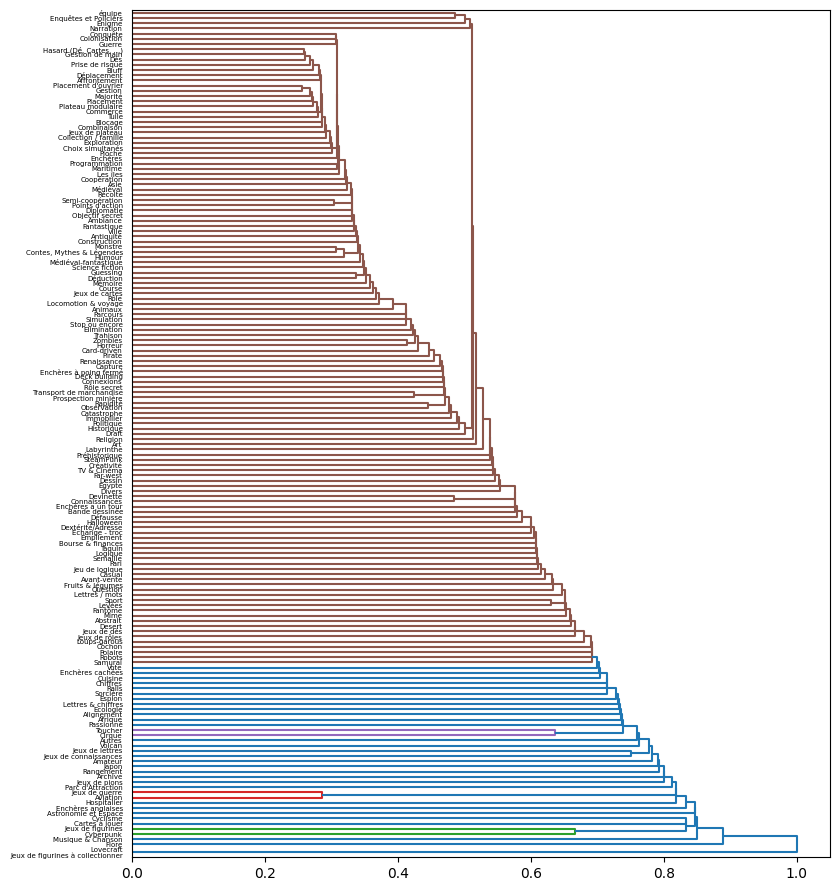

In [18]:
# co/bi clustering and hierarchical clustering on it
from scipy.cluster.hierarchy import linkage, dendrogram

# dendogram clustering on labels

# clustering the categories 
plt.figure(figsize=(9,11))
Y = linkage(co_occ_norm, metric='jaccard') 
_ = dendrogram(Y, orientation='right', labels=co_occ.columns)
plt.tick_params(axis='y', labelsize=5) 
plt.show()

/tmp/ipykernel_13338/489551784.py:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(co_occ, method='ward')


cluster  1
Index(['Abstrait', 'Afrique', 'Alignement', 'Amateur', 'Archive', 'Art',
       'Astronomie et Espace', 'Autres', 'Avant-vente', 'Aviation',
       'Bande dessinée', 'Bourse & finances', 'Cartes à jouer', 'Casual',
       'Chiffres', 'Cirque', 'Cochon', 'Connaissances', 'Créativité',
       'Cuisine', 'Cyberpunk', 'Cyclisme', 'Desert', 'Dessin', 'Devinette',
       'Divers', 'Draft', 'Défausse', 'Echange - troc', 'Ecologie', 'Egypte',
       'Empilement', 'Enchères a un tour', 'Enchères anglaises',
       'Enchères cachées', 'Enchères à poing fermé', 'Enigme', 'Espion',
       'Fantôme', 'Far-west', 'Flore', 'Fruits & légumes', 'Halloween',
       'Historique', 'Hospitalier', 'Japon', 'Jeu de logique',
       'Jeux de connaissances', 'Jeux de dés', 'Jeux de figurines',
       'Jeux de figurines à collectionner', 'Jeux de guerre',
       'Jeux de lettres', 'Jeux de pions', 'Jeux de rôles',
       'Lettres & chiffres', 'Lettres / mots', 'Levées', 'Logique',
       'Loups-garou

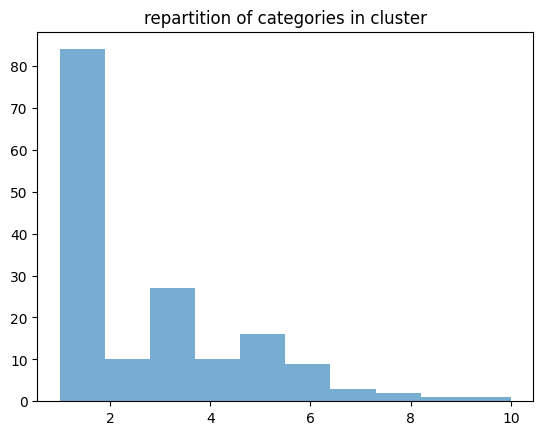

In [19]:
# # apply clustering from hierarchical clustering
from scipy.cluster.hierarchy import fcluster

ncluster = 10

linkage_matrix = linkage(co_occ, method='ward')
fl = fcluster(linkage_matrix,ncluster,criterion='maxclust')
plt.title("repartition of categories in cluster")
plt.hist(fl, alpha = 0.6)

for i in range(1, ncluster):
    print("cluster ", i)
    print(co_occ.index[np.where(fl == i)[0]])

In [21]:
# # hierarchical clustering, categories of clustered games

# ncluster = 6

# linkage_matrix = linkage(co_occ, method='ward')
# fl = fcluster(linkage_matrix,ncluster,criterion='maxclust')
# fig, axes = plt.subplots(2, 3, figsize=(10, 6))
# clust = 1

# for i in range(3):
#     for j in range(3):
#         if clust > max(fl):
#             break
#         ax = axes[i, j]  # Get the axis for each subplot
#         # For each clusters find associated tags
#         cluster_cat = co_occ.loc[:, (co_occ.loc[co_occ.index[np.where(fl == clust)]] != 0).any(axis=0)] 
#         # cluster_cat = user_type.loc[:, (user_type.loc[co_occ_user_norm.index[np.where(fl == clust)]] != 0).any(axis=0)] 
#         print(cluster_cat.shape)
#         # Calculate the frequency of tags in the current cluster
#         most_pop_clusters = ["Jeux de plateau", "Jeux de cartes", "Hasard (Dé, Cartes, ...)", "Placement", "Affrontement", "Combinaison", "Bluff"]
#         cluster_cat = cluster_cat.drop(columns = most_pop_clusters, errors='ignore')
        
#         tag_frequency = (cluster_cat != 0).sum(axis=0) / (cluster_cat != 0).sum().sum()

#         # Plot the frequency
#         tag_frequency.nlargest(20).plot(kind='barh', color='skyblue', ax=ax) 
        
#         # Set the title and axis labels with appropriate fontsize
#         ax.set_title(f'Frequency of tags in tags clusters {clust}', fontsize=10)
#         ax.set_xlabel('Frequency', fontsize=8) 
#         ax.set_ylabel('Tags', fontsize=8)
#         ax.tick_params(axis='both', which='major', labelsize=7)
#         ax.set_xticks(ax.get_xticks())

#         clust += 1

# plt.tight_layout()

# plt.show()

In [25]:
# # bi/coclustering visualise tags frequency among game clusters 
# from sklearn.cluster import SpectralBiclustering, SpectralCoclustering
# Nclus = 6
# mat = co_occ
# clustering = SpectralCoclustering(n_clusters=Nclus, random_state=0).fit(mat) 

# fig, axes = plt.subplots(3, 3, figsize=(13, 8))
# clust = 0
# for i in range(3):
#     for j in range(3):
#         if clust >= Nclus:
#             break
        
#         ax = axes[i, j]  # Get the axis for each subplot
        
#         # Filter the DataFrame (clust)
#         cluster_cat = mat.loc[:, (mat.loc[mat.index[np.where(clustering.row_labels_ == clust)]]!= 0).any(axis=0)]
#         # cluster_cat = user_type.loc[:, (user_type.loc[mat.index[np.where(clustering.row_labels_ == clust)]] != 0).any(axis=0)] 
#         print(cluster_cat.shape)
#         # Calculate the frequency of tags in the current cluster
#         pop_tags = ["Jeux de plateau", "Jeux de cartes", "Hasard (Dé, Cartes, ...)", "Placement", "Affrontement", "Combinaison"]
#         cluster_cat = cluster_cat.drop(columns=pop_tags, errors='ignore')
#         tag_frequency = (cluster_cat != 0).sum(axis=0) / (cluster_cat != 0).sum().sum()

#         # Plot the frequency
#         tag_frequency.nlargest(10).plot(kind='barh', color='skyblue', ax=ax)
        
#         ax.set_title(f'Frequency of tags in game cluster {clust}', fontsize=10)
#         ax.set_xlabel('Frequency', fontsize=8) 
#         ax.set_ylabel('Tags', fontsize=8)
#         ax.tick_params(axis='both', which='major', labelsize=7)
#         ax.set_xticks(ax.get_xticks())

#         clust += 1

# plt.tight_layout()
# plt.show()

In [22]:
# # see the clustered categories

# from sklearn.cluster import SpectralBiclustering, SpectralCoclustering
# Nclus = 15
# mat = co_occ
# clustering = SpectralCoclustering(n_clusters=Nclus, random_state=0).fit(mat) 

# for clust in np.unique(clustering.row_labels_):
#     m = mat.index[np.where(clustering.row_labels_ == clust)]
#     print(m, m.shape)